In [1]:
import numpy as np
# from matplotlib import pyplot as plt
from time import time

import pyesapi
import atexit
app = pyesapi.CustomScriptExecutable.CreateApplication('python_demo')
atexit.register(app.Dispose);

In [94]:
# import streamlit as st
# from streamlit_jupyter import StreamlitPatcher, tqdm
# StreamlitPatcher().jupyter()  # register streamlit with jupyter-compatible wrappers

In [74]:
import pandas as pd
import chart_studio.plotly as py
import plotly.figure_factory as ff
from plotly.offline import iplot

In [3]:
for pat in app.PatientSummaries:
    print(pat.Id, pat.LastName, pat.FirstName)

CCS OncQT Sunday_Rob CCS OncQT
2274444 Zlack James
Eclipse01 Holy Name PET Case 1C 
2277755 Black James
SRS-Lung Baker Josephin
00IGRT_50 Protosky Pekka
00IGRT21 Headly Nick
00IGRT71 Lundgren Larry
00IGRT67 Seddon Ron
00IGRT66 Jones Harold
00IGRT65 Pearlman Samuel
00IGRT64 Jones Melody
00IGRT41 Bladder Blake
00IGRT42 Prosser Pedro
00IGRT43 Lunn Luke
00IGRT01 Lundahl Esau
00IGRT44 Benson Brigitte
00IGRT61 Peter Pelllhum
00IGRT62 Pelton Paul
00IGRT_85 Peltz Reginald
00IGRT_87 Long Henry
00IGRT_90 Pellman Elvis
00IGRT_86 Lunsford Andy
00IGRT_88 Pelletier Richard
00IGRT_89 Denton Margaret
Eclipse_18 Rt Lung Tumor RA, DRR
MK11111 Mike Arinas
11133313 Female MR2 CCS Test
MR30928 Smythe Janine
5563207 Cote Pearl
MR1234 Demont Patricia
MR43729 Smith David
100665241 Pancher Harold
MR039547 Flannigan Patrice
2587413 James Susan T
1897856 Arrows Gail
MR09395 Newberry Sara
MR83943 O'Malee Candace
9876548 Janzen Joyce T
2563149 Jamieson Everett T
MR37438 Smyth Jannine
2587469 Jacobson Randolph T
43

In [50]:
# --plan-id "10x IMRT1" --course-id "TrueBeam" --patient-id "Eclipse-02"
app.ClosePatient()
patient = app.OpenPatientById('Eclipse-02')
plan = patient.CoursesLot('TrueBeam').PlanSetupsLot('TB 10X 2arc')#'10x IMRT1')
structures = plan.StructureSet.StructuresLot()
print(f'plan id: {plan.Id}\nstructure set id: {plan.StructureSet.Id}')

plan id: TB 10X 2arc
structure set id: C1


In [63]:
# load field data
df = None
print("Extracting beam data...")
for beam in plan.Beams:
    beamMetersetValue = beam.Meterset.Value
    totMetersetWeight = [cpp for cpp in beam.ControlPoints][-1].MetersetWeight
    eParams = beam.GetEditableParameters()
#    for idx, controlPoint in enumerate(eParams.ControlPoints):
    df = pd.concat([beams_df, pd.DataFrame({
        'Field ID': beam.Id,
        'MU': np.diff(np.array([0]+[cp.MetersetWeight for cp in eParams.ControlPoints])*beamMetersetValue/totMetersetWeight),
        'Gantry Angle' : [cp.GantryAngle for cp in eParams.ControlPoints]
        # add other data elments of interest here
    })])
st.dataframe(df)

Extracting beam data...


,Field ID,MU,Gantry Angle
0,Field 1,0.000000,181.000000
1,Field 1,0.613271,182.017045
2,Field 1,1.226542,184.051136
3,Field 1,1.226542,186.085227
4,Field 1,1.226542,188.119318
...,...,...,...
173,Field 2,1.477133,188.119318
174,Field 2,1.477133,186.085227
175,Field 2,1.477133,184.051136
176,Field 2,1.477133,182.017045


In [86]:
# load structure data
structures_df = None
for structure in plan.StructureSet.Structures:
    dvh = plan.GetDVHCumulativeData(
        structure,
        pyesapi.DoseValuePresentation.Relative,
        pyesapi.VolumePresentation.Relative,
        .1
    )
    if dvh is not None:
        structures_df = pd.concat([structures_df, pd.DataFrame({
            'Structure ID': structure.Id,
            'Color': "#" + structure.Color.ToString()[3:],  # format is '#AARRGGBB'
            'Dose %': [p.DoseValue.Dose for p in dvh.CurveData],
            'Volume %': [p.Volume for p in dvh.CurveData],
        })])

In [91]:
dfc = None
for beam in plan.Beams:
    plan_target = plan.StructureSet.StructuresLot(plan.TargetVolumeID)
    for idx, contour in enumerate(beam.GetStructureOutlines(plan_target,True)):
        dfc = pd.concat([dfc, pd.DataFrame({
            'Beam ID' : beam.Id,
            'Structure ID': plan_target.Id,
            'Color': '#' + plan_target.Color.ToString()[3:],
            'Points X' : [p.X for p in contour],
            'Points Y' : [p.Y for p in contour],
            'Contour Idx' : idx,
        })])

### Field 1

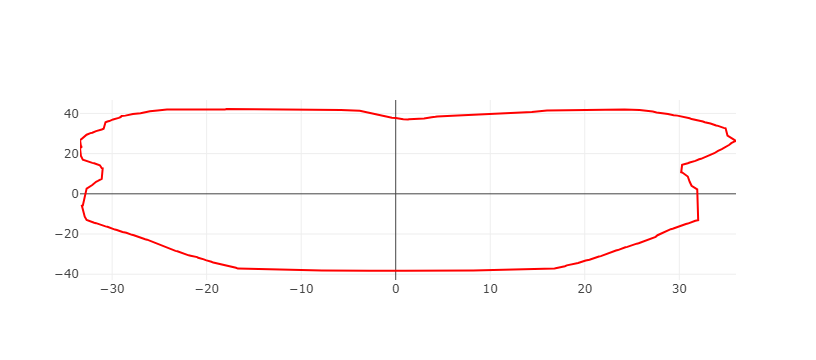

### Field 2

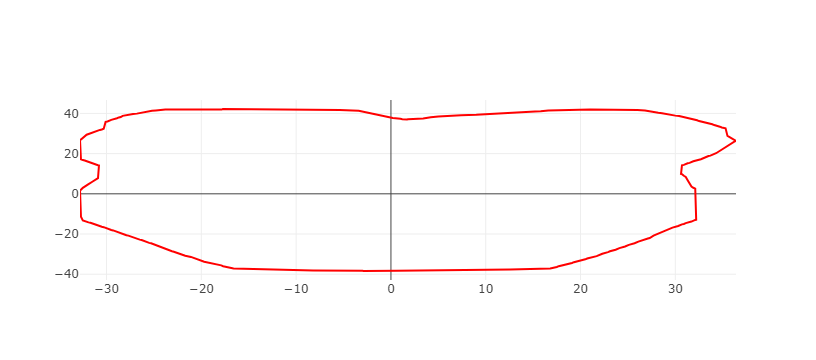

In [96]:
import plotly.express as px
import plotly.graph_objects as go
for fld_name, field_df in df.groupby('Field ID'):
    st.subheader(fld_name)
    fig_scatt = None

    for _, dfc_field in dfc[dfc['Beam ID'] == fld_name].groupby('Contour Idx'):
        structure_id = dfc_field['Structure ID'][0]
        fig_scatt = go.Figure([go.Scatter(
            x=dfc_field['Points X'], y=dfc_field['Points Y'], mode='lines',
            name=structure_id)]
        )
        fig_scatt.update_traces(line_color=dfc_field['Color'][0], selector=dict(name='PTV'))

    #st.plotly_chart(fig_scatt, use_container_width=True)
    iplot(fig_scatt)